In [296]:
import pandas as pd
import numpy as np
import operator
from pandas.tseries.offsets import DateOffset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [297]:
tweets= pd.read_csv('../data/chesou.csv')
start_time=datetime(2015,10,3,17,30,0)

In [298]:
tweets['created_at'] = pd.to_datetime(pd.Series(tweets['created_at'])).apply(lambda d: d + timedelta(hours=1))

In [299]:
fh_added_time=2
sh_added_time=10
threshold=0
diff_threshold = 100 # only spikes with difference in tweet count in a minute greater than this value is considered.

In [300]:
def to_min_fh(d):
    d = d + timedelta(seconds=threshold*60)
    minute = (86400* (d-start_time).days + (d-start_time).seconds)/60
    return minute

In [301]:
def filter_tweets_divided(tweets):
    filtered = tweets[tweets['m'] > 0]
    filtered = filtered[filtered['m'] < 120]
    #return filtered
    #filtered = filtered[(filtered['text'].str.contains('CHEARS'))]
    #filtered = filtered[(filtered['text'].str.contains('CFC')) 
    #                   | (filtered['text'].str.contains('AFC'))
    #                  ]
    return filtered

In [302]:
def half_tweets(tweets):
    first_half = tweets[tweets['m']< 50]
    second_half = tweets[(tweets['m'] > 60) & (tweets['m'] < 120)]
    return first_half, second_half

In [303]:
tweets['m']=tweets.created_at.apply(to_min)

In [304]:
first_half, second_half = half_tweets(tweets)
fh_filtered=filter_tweets_divided(first_half)
sh_filtered=filter_tweets_divided(second_half)
sh_filtered['m'] = sh_filtered.m.apply(lambda d: d - 15 - fh_added_time)

In [305]:
grouped_fh = fh_filtered.groupby('m').count()
grouped_sh = sh_filtered.groupby('m').count()

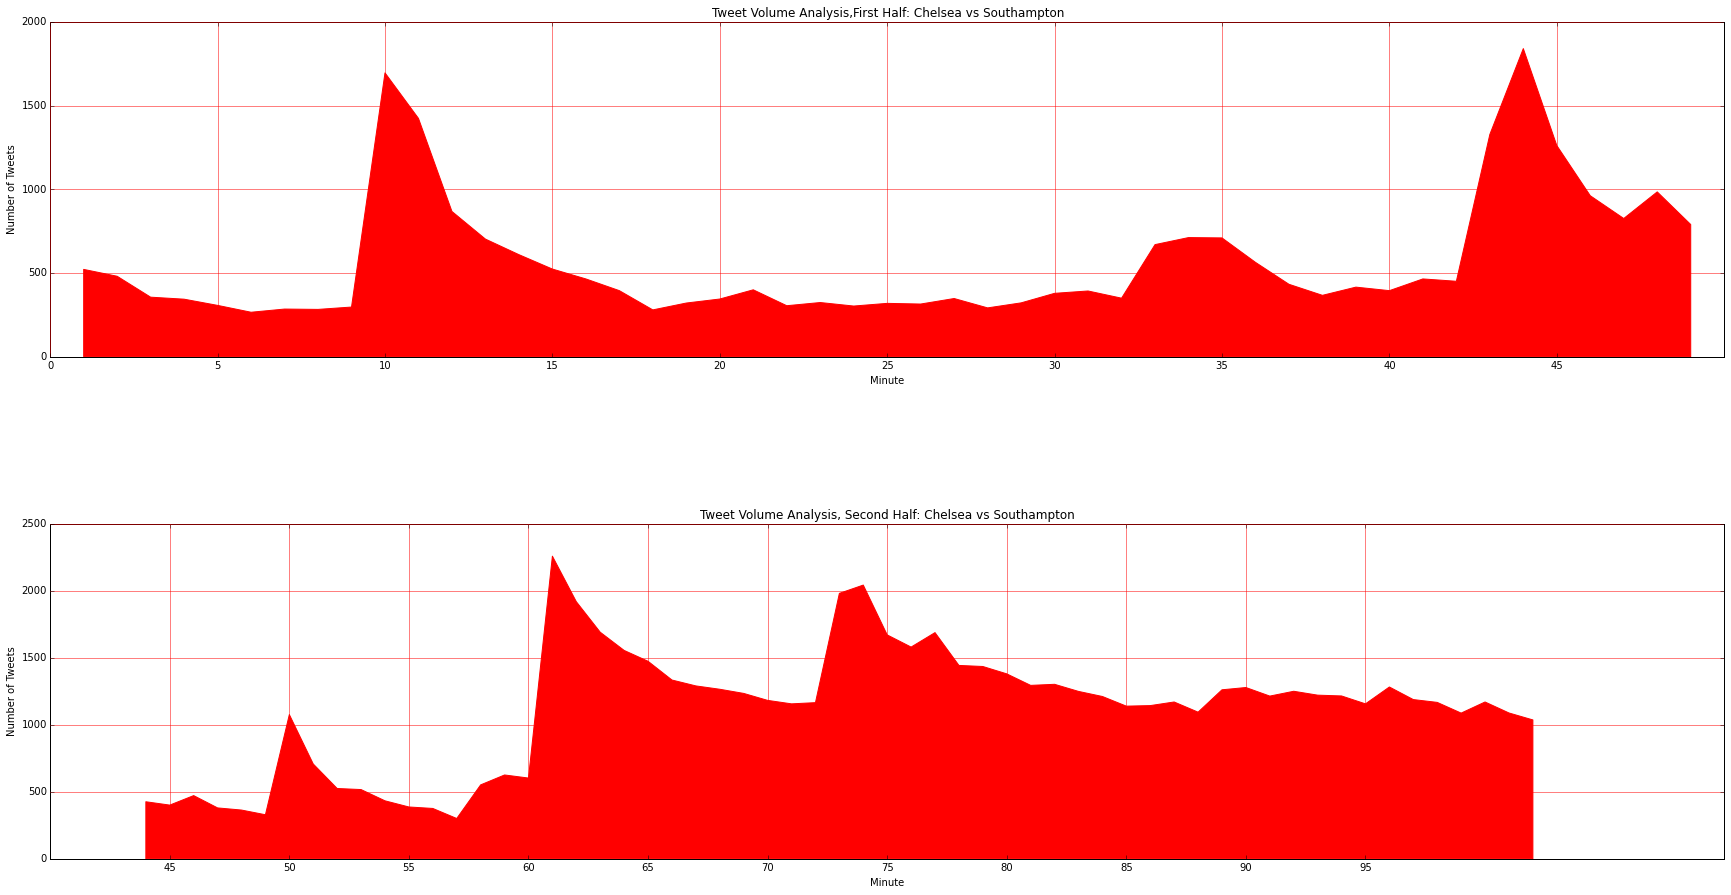

In [306]:
# let us make a simple graphfh
fig = plt.figure(figsize=[30,15])
plt.subplots_adjust(hspace=.5)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,100,5))


plt.subplot2grid((2,2), (0,0), colspan=2)
plt.fill_between(grouped_fh.index, grouped_fh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis,First Half: Chelsea vs Southampton')
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(0,50,5))

plt.subplot2grid((2,2), (1,0), colspan=2)
plt.fill_between(grouped_sh.index, grouped_sh['text'], color='red')
# set the basic properties
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Analysis, Second Half: Chelsea vs Southampton')
# set the limits
#ax.set_xlim(0, 24)
#ax.set_ylim(6, 24)

# set the grid on
plt.grid(color='r', linestyle='-', linewidth=0.5, which='major')
plt.xticks(range(45,100,5))
fig.savefig('../plots/chesou.png')

In [307]:
class Spike(object):
    def __init__(self, start, end,diff, df):
        self.start = start
        self.end = end
        self.dur = dur
        self.diff = diff
        self.slope = diff/float(self.end - self.start)
    
    def fill_tweets(self, df):
        self.tweets = df[(df.m > self.start) & (df.m <= self.end)]['text'].values
        
    def __str__(self):
        return '%d-%d, diff:%d, slope:%d' %(self.start, self.end, self.diff, self.slope)

In [308]:
def get_spikes(grouped, start=0):
    row = 0
    spikes = []
    while True:
        cur_tweet_count = grouped.values[row][0]
        start_index = row
        end_index = row
        diff = 0
        row = row + 1
        if not row + start >= np.max(grouped.index.values):
            next_tweet_count = grouped.values[row][0]
            while next_tweet_count - cur_tweet_count > diff_threshold:
                end_index = row
                diff += next_tweet_count - cur_tweet_count
                cur_tweet_count = grouped.values[row][0]
                row = row + 1
                if not row + start >= np.max(grouped.index.values):
                    next_tweet_count = grouped.values[row][0]
                else:
                    break
            if end_index - start_index > 0:
                spikes.append(Spike(start_index + start, end_index + start, diff, grouped))

        else:
            break
    spikes.sort(key=operator.attrgetter('diff'), reverse=True)
    return spikes

In [312]:
fh_spikes = get_spikes(grouped_fh, 1)
sh_spikes = get_spikes(grouped_sh, 45)
for spike in fh_spikes:
    spike.fill_tweets(fh_filtered)
for spike in sh_spikes:
    spike.fill_tweets(sh_filtered)